##### Learning exercise --- diffusion-advection-reaction equation
$$ \frac{\partial^2 u}{\partial x^2} - P_e \frac{\partial u}{\partial x} + D_a u(1-u) = 0 \quad \forall x \in [0, 1] $$
$$ u(0)=u(1)=1 $$

* $P_e = 0.01$ is the non-dimensional Peclet number that measures the strength of the advection to the diffusion
* $D_a = 0.01$ is the non-dimensional Damkohler number that measures the strength of thereaction to the diffusion

Approximate the solution to the PDE using a PINN, i.e, $\hat{u}(x, t) = \mathcal{NN}(x, t)$, trained with the following loss function:
$$\mathcal{L} := \mathcal{L}_{\mathrm{PDE}} + \lambda_{\mathrm{BC}} \mathcal{L}_{\mathrm{BC}}, $$ 
where $\lambda_{\mathrm{BC}} = 10.0 $, 

$$\mathcal{L}_{\mathrm{PDE}} = \frac{1}{N} \sum_{i=1}^{N} \left( \frac{\partial^2 \hat{u}(x^{(i)})}{\partial x^2} - P_e \frac{\partial \hat{u}(x^{(i)})}{\partial x} + D_a \hat{u}(x^{(i)}) (1 - \hat{u}(x^{(i)}))  \right)^2,$$ 
$ N = 100$ and
$$ \mathcal{L}_{\mathrm{BC}} = \left( \hat{u}(0) \right)^2 + \left( \hat{u}(1) - 1 \right)^2 $$

#### Steps
1. Import necessary modules and packages, and manually fix the seed. 
2. Define a function to initialize a fully-connected neural network which will approximate the solution (from previous tutorial)
3. Define a function to compute the PINNs loss
4. Train the neural network
5. Plot the loss and the solution to the diffusion-advection-reaction equation

#### Import packages, set seed and define function for neural network

In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt

seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


class NeuralNetwork(torch.nn.Module):
    def __init__(self, input_dim=2, output_dim=1, width=5, depth=3, activation='relu'):
        super().__init__()
        self.input_dim = input_dim          # input dimension
        self.output_dim = output_dim        # output dimension
        self.width = width                  # width of hidden layers
        self.depth = depth                  # number of hidden layers + output layer
        if activation == 'relu':
            self.activation = torch.nn.ReLU()
        elif activation == 'tanh':
            self.activation = torch.nn.Tanh()
        else:
            raise ValueError('activation must be one of "relu", "tanh", or "sin"')
        
        self.modules = []
        self.modules.append(torch.nn.Linear(input_dim, width))  # input layer
        self.modules.append(self.activation)                    # activation function
        for _ in range(depth-1):
            self.modules.append(torch.nn.Linear(width, width))  # hidden layers
            self.modules.append(self.activation)                # activation function
        
        self.modules.append(torch.nn.Linear(width, output_dim)) # output layer
        self.net = torch.nn.Sequential(*self.modules)           # combine all layers

    def forward(self, x):
        return self.net(x)

/Users/adasgupta/miniconda3/envs/NFOIS/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Loss function

In [13]:
def pinns_loss(net, x, x_lb, x_rb, Pe, Da):
    '''Compute the loss function for the PINNs
    Args:
        net: torch.nn.Module, neural network
        x: torch.Tensor, space points for PDE loss, shape (N, 1)
        x_lb: torch.Tensor, space points for left boundary condition, shape (1, 1), x_lb = 0
        x_rb: torch.Tensor, space points for right boundary condition, shape (1, 1), x_rb = 1
        Pe: float, Peclet number
        Da: float, Damkohler number
    '''
    # Compute the solution
    u = net(x)
    
    # Compute the gradients of u w.r.t. x
    u_x = torch.autograd.grad(u, x, torch.ones_like(u), create_graph=True)[0]

    # Compute the second derivative of u w.r.t. x
    u_xx = torch.autograd.grad(u_x, x, torch.ones_like(u_x), create_graph=True)[0]

    # Compute the loss function
    l_pde = u_xx - Pe*u_x + Da*u*(1.0 - u) # PDE loss

    # Compute the boundary condition loss
    l_lbc = net(x_lb) # loss at left boundary @ x = 0
    l_rbc = 1.0 - net(x_rb) # loss at right boundary @ x = 1

    loss = torch.mean(l_pde**2) + 300*torch.mean(l_lbc**2) + 300*torch.mean(l_rbc**2) # total loss
    return loss

#### Creating the collocation, boundary and initial condition training points

In [14]:
Pe = 20.0   # Peclet number
Da = 0.01   # Damkohler number

N = 100    # number of collocation points

# Generate collocation points
x_collocation = torch.linspace(0, 1, N, requires_grad=True).reshape(-1,1)

# Boundary points
x_lb = torch.zeros(1,1, requires_grad=True)
x_rb = torch.ones(1,1, requires_grad=True)

#### Neural network -- Training

In [15]:
model = NeuralNetwork(input_dim=1, output_dim=1, width=18, depth=6, activation='tanh')
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
loss_history = []   # history of loss function values
model.train()       # set the model to training mode
for i in range(40000):
    optimizer.zero_grad()           # clear the gradients
    loss = pinns_loss(model, x_collocation, x_lb, x_rb, Pe, Da)   # compute the loss function
    loss.backward(retain_graph=True)    # backpropagate the gradients
    optimizer.step()                    # update the weights
    loss_history.append(loss.item())    # save the loss function value

Plot the loss history

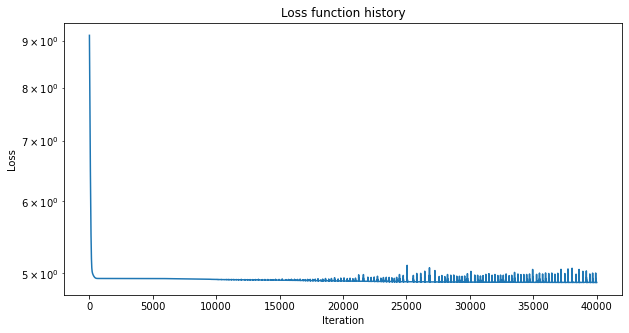

In [11]:
plt.figure(figsize=(10, 5))
plt.plot(loss_history)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.yscale('log')
plt.title('Loss function history')
plt.show()

Plot the solution

Text(0.5, 1.0, 'Solution of the PDE for Pe=20.0, Da=0.01')

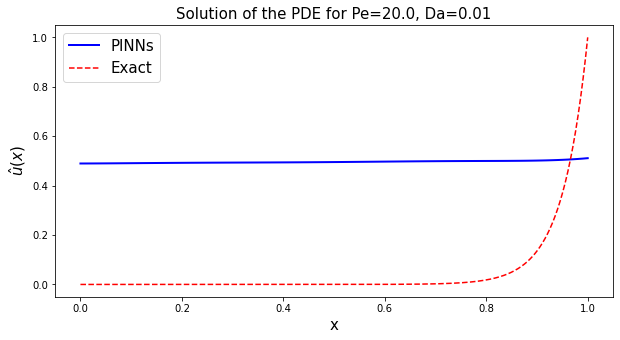

In [12]:
u = model(x_collocation).detach().numpy()
x_c = x_collocation.detach().numpy()

if Pe==0.01 and Da==0.01:
    X = np.loadtxt('./assets/Pe_001_Da_001.txt')
if Pe==20.0 and Da==0.01:
    X = np.loadtxt('./assets/Pe_20_Da_001.txt')
if Pe==0.01 and Da==60.0:
    X = np.loadtxt('./assets/Pe_001_Da_60.txt')
if Pe==15.0 and Da==40.0:
    X = np.loadtxt('./assets/Pe_15_Da_40.txt')


plt.figure(figsize=(10, 5))
plt.plot(x_c, u, 'b-', lw=2, label='PINNs')
plt.plot(X[:,0], X[:,1], 'r--', label='Exact')
plt.legend(fontsize=15)
plt.xlabel('x', fontsize=15)
plt.ylabel(r'$\hat{u}(x)$', fontsize=15)
plt.title('Solution of the PDE for Pe='+str(Pe)+', Da='+str(Da), fontsize=15)